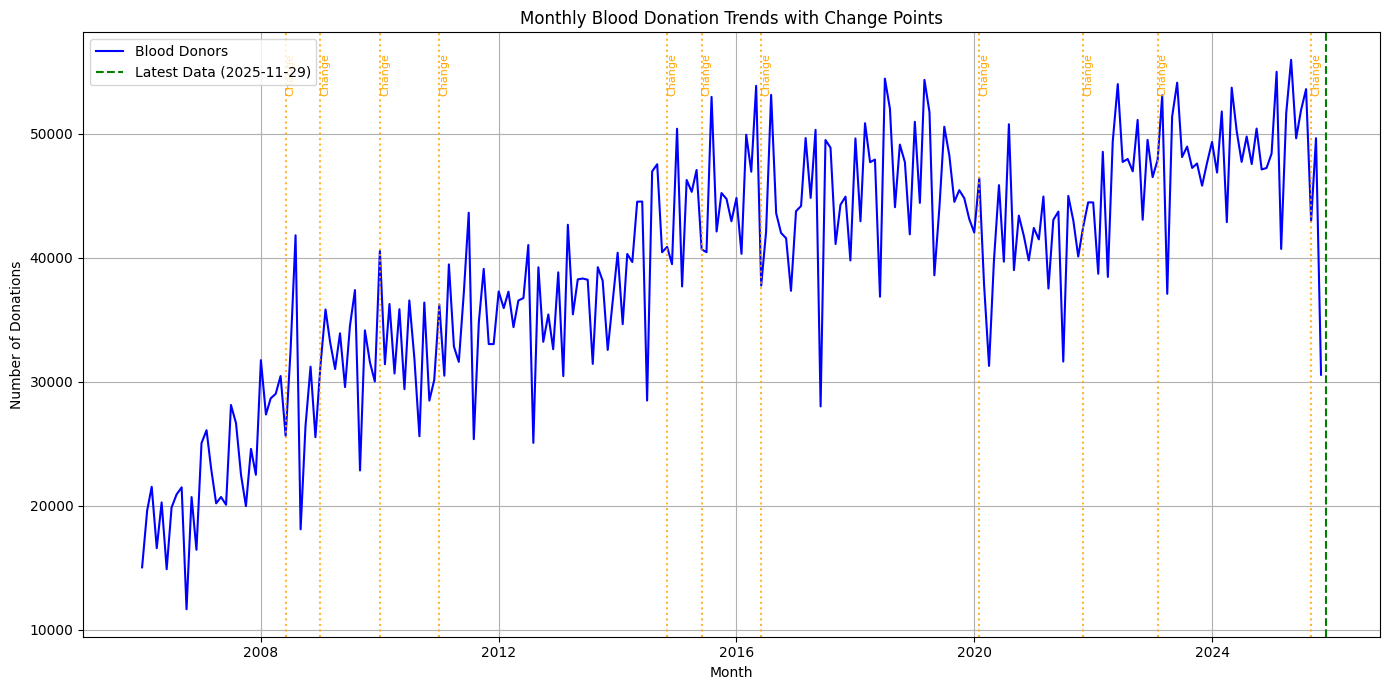

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB database
conn = duckdb.connect("../donations.duckdb")

# Query data
complete_df = conn.execute("SELECT visit_date FROM complete_donor").fetchdf()
complete_df['visit_date'] = pd.to_datetime(complete_df['visit_date'])

# Aggregate by month
complete_monthly = complete_df.groupby(complete_df['visit_date'].dt.to_period('M')).size().reset_index(name='donations')
complete_monthly['visit_date'] = complete_monthly['visit_date'].dt.to_timestamp()

# Latest date
latest_date = complete_df['visit_date'].max()

# Change point detection
window = 6  # 6-month rolling window
complete_monthly['rolling_mean'] = complete_monthly['donations'].rolling(window=window, center=True).mean()
diffs = complete_monthly['rolling_mean'].diff()
threshold = diffs.std() * 2
change_points = complete_monthly.loc[abs(diffs) > threshold, 'visit_date']

# Plot
plt.figure(figsize=(14, 7))
plt.plot(complete_monthly['visit_date'], complete_monthly['donations'], label='Blood Donors', color='blue')
plt.axvline(x=latest_date, color='green', linestyle='--', label=f'Latest Data ({latest_date.date()})')

# Highlight change points
for cp in change_points:
    plt.axvline(x=cp, color='orange', linestyle=':', alpha=0.8)
    plt.text(cp, complete_monthly['donations'].max()*0.95, 'Change', rotation=90, color='orange', fontsize=8)

plt.title('Monthly Blood Donation Trends with Change Points')
plt.xlabel('Month')
plt.ylabel('Number of Donations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('donation_trends_change_points.png')
plt.show()


- Detects significant shifts in donation patterns using a simple rolling mean difference approach:
    - Calculates a 6-month rolling average.
    - Flags months where the change exceeds 2× the standard deviation of differences.
- Highlights change points on the chart with orange dashed lines.
- Annotates these points for clarity.


✅ Why This Adds Insight

- The public can now see when donation behavior changed significantly (e.g., due to campaigns, seasonal effects, or external events).
- Makes the visualization actionable and interesting rather than just a trend line.

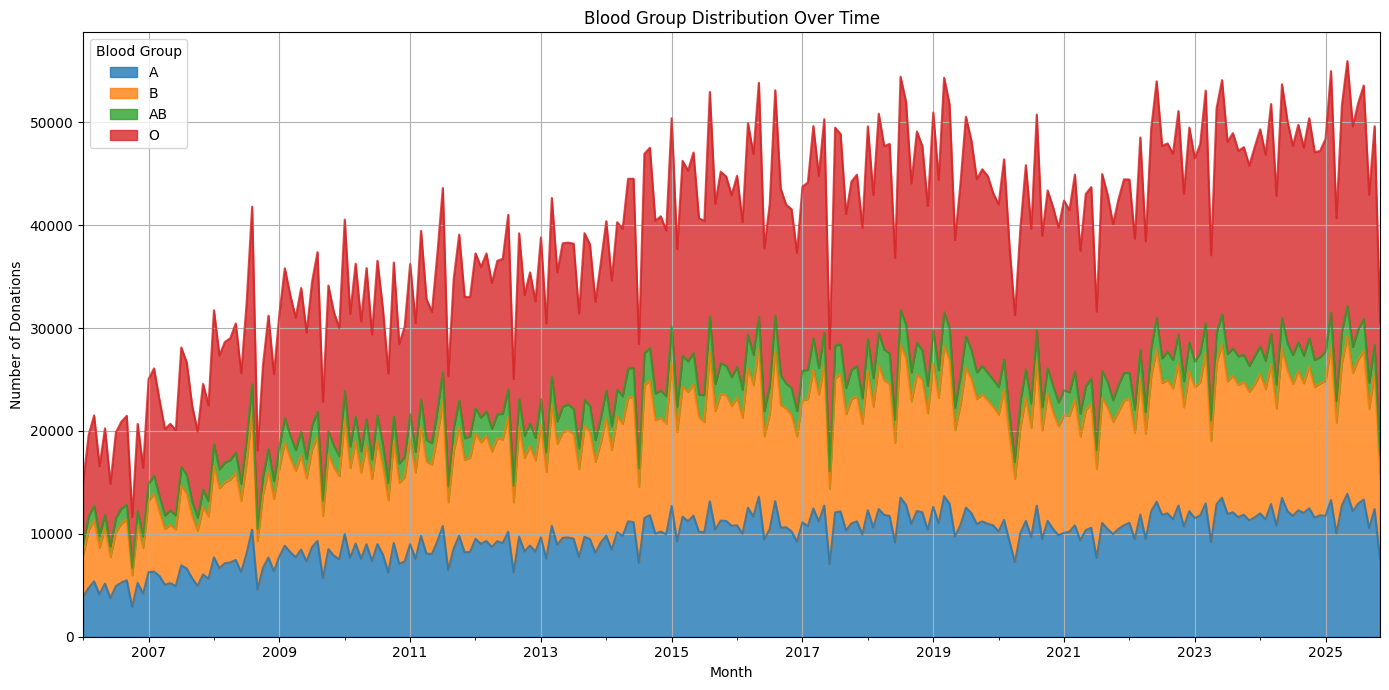

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB database
conn = duckdb.connect("../donations.duckdb")

# Query blood group data
query = "SELECT visit_date, blood_group FROM complete_donor WHERE blood_group IS NOT NULL"
df = conn.execute(query).fetchdf()

# Convert visit_date to datetime
df['visit_date'] = pd.to_datetime(df['visit_date'])

# Aggregate by month and blood group
df_grouped = df.groupby([df['visit_date'].dt.to_period('M'), 'blood_group']).size().reset_index(name='count')
df_grouped['visit_date'] = df_grouped['visit_date'].dt.to_timestamp()

# Pivot for stacked area chart
pivot_df = df_grouped.pivot(index='visit_date', columns='blood_group', values='count').fillna(0)

# Sort columns for consistent order
if set(['A','B','AB','O']).issubset(pivot_df.columns):
    pivot_df = pivot_df[['A', 'B', 'AB', 'O']]

# Plot stacked area chart
plt.figure(figsize=(14, 7))
pivot_df.plot.area(ax=plt.gca(), alpha=0.8)

plt.title('Blood Group Distribution Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Donations')
plt.legend(title='Blood Group')
plt.grid(True)
plt.tight_layout()
plt.savefig('blood_group_distribution.png')


✅ Why This Is Insightful
- Shows dominant blood groups over time.
- Detects seasonal or demographic shifts.
- Useful for public awareness campaigns (e.g., if O blood group is consistently high demand).

  age_group  total_donors  repeat_donors  retention_rate
0     20-29        590966         247255       41.839124
1     30-39        853004         425013       49.825440
2     40-49        532453         289004       54.277842
3       50+        354568         194603       54.884536
4       <20         19919           3225       16.190572


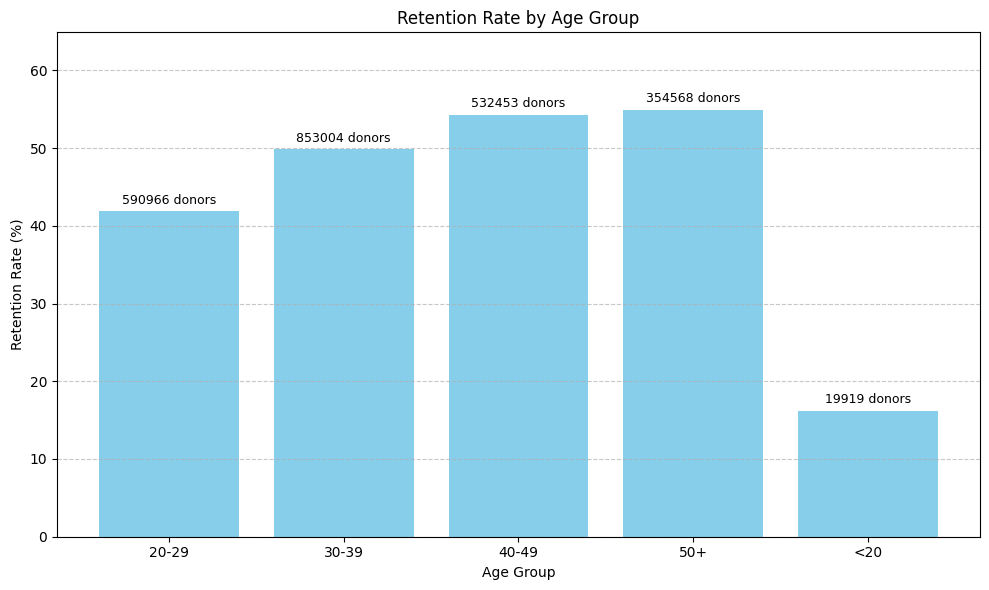

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to DuckDB
conn = duckdb.connect("../donations.duckdb")

# Load daily_retention
df = conn.execute("SELECT donor_id, visit_date, birth_date FROM daily_retention").fetchdf()

if df.empty:
    print("⚠️ No data found in daily_retention.")
else:
    # Calculate age
    current_year = datetime.now().year
    df['age'] = current_year - df['birth_date'].astype(int)

    # Count visits per donor
    visit_counts = df.groupby(['donor_id', 'age']).size().reset_index(name='visit_count')

    # Assign age groups
    def age_group(age):
        if age < 20: return '<20'
        elif age < 30: return '20-29'
        elif age < 40: return '30-39'
        elif age < 50: return '40-49'
        else: return '50+'

    visit_counts['age_group'] = visit_counts['age'].apply(age_group)

    # Calculate retention
    total_donors = visit_counts.groupby('age_group')['donor_id'].nunique()
    repeat_donors = visit_counts[visit_counts['visit_count'] > 1].groupby('age_group')['donor_id'].nunique()
    retention_rate = (repeat_donors / total_donors * 100).fillna(0)

    # Combine into DataFrame
    retention_age_df = pd.DataFrame({
        'age_group': total_donors.index,
        'total_donors': total_donors.values,
        'repeat_donors': repeat_donors.reindex(total_donors.index, fill_value=0).values,
        'retention_rate': retention_rate.values
    })

    print(retention_age_df)

    # Plot
    if not retention_age_df.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(retention_age_df['age_group'], retention_age_df['retention_rate'], color='skyblue')

        # Annotate total donors
        for idx, row in retention_age_df.iterrows():
            plt.text(idx, row['retention_rate'] + 1, f"{row['total_donors']} donors", ha='center', fontsize=9)

        plt.title('Retention Rate by Age Group')
        plt.xlabel('Age Group')
        plt.ylabel('Retention Rate (%)')
        plt.ylim(0, retention_age_df['retention_rate'].max() + 10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('retention_by_age_group.png')
        plt.show()
    else:
        print("⚠️ No data to plot.")


In [ ]:
conn.close()